<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Basics on Neural Latent SDE
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Biblio
</div>

Neural ODEs:

**Neural ODEs (https://arxiv.org/abs/1806.07366) (2019)** : introduction of the Neural ODE as the continuous-time limit of a ResNet stack. Presentation of the use of the adjoint sensitivity method. Seminal paper for Neural ODE.

**Latent ODEs for Irregularly-Sampled Time Series (https://arxiv.org/abs/1907.03907) (2019)** : Evolution of the Neural ODE model towards a Neural ODE RNN model, where the approximate posterior is built with a RNN on past observations.

Neural SDEs:

**SDE Matching: Scalable and Simulation-Free Training of Latent Stochastic Differential Equations (https://arxiv.org/abs/2502.02472 , 2025)** : good background section (#2) to explain Neural SDE. Propose a new method SDE matching, inspired by score and flow matching, vs the adjoint sensivity method. SDE matching is claimed to be more efficient to compute gradients and train latent SDEs.

**Scalable Gradients for Stochastic Differential Equations (https://arxiv.org/abs/2001.01328) (2020)** : generalization of the adjoint sensitivity method to SDEs. Combination with gradient-based stochastic variational inference for infinite-dimension VAEs.

**Neural SDEs (https://www.researchgate.net/publication/333418188_Neural_Stochastic_Differential_Equations) (2019)** : link between infinitely deep residual networks and solutions to stochastic differential equations

**Stable Neural SDEs in analyzing irregular time series data (https://arxiv.org/abs/2402.14989) (2025)** : points to the necessity of careful design of the drift and diffusion neural nets in latent SDEs. Introduces three latent SDEs models with performance guarantees.

**Generative Modeling of Neural Dynamics via Latent Stochastic Differential Equations (https://arxiv.org/abs/2412.12112) (2024)** : application of neural SDEs to a biological use case (brain activity). Details the model, architecture, ELBO/loss computation. Takes into account inputs/commands in the model. 

General/Misc:

**Efﬁcient gradient computation for dynamical models (https://www.fil.ion.ucl.ac.uk/~wpenny/publications/efficient_revised.pdf) (2014)** : summary of finite difference method, forward sensitivity method, adjoint sensitivity method, to compute gradients of a functional cost function. Applies to Neural ODEs training.

**Cyclical Annealing Schedule: A Simple Approach to Mitigating KL Vanishing (https://arxiv.org/abs/1903.10145) (2019)** : explanation of the posterior collapse/KL vanishing problem, introduces different KL annealing schedules for VAE training.


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Code : torchsde library by Google Research
</div>

https://github.com/google-research/torchsde

[1] Xuechen Li, Ting-Kam Leonard Wong, Ricky T. Q. Chen, David Duvenaud. "Scalable Gradients for Stochastic Differential Equations". International Conference on Artificial Intelligence and Statistics. 2020. [arXiv]

[2] Patrick Kidger, James Foster, Xuechen Li, Harald Oberhauser, Terry Lyons. "Neural SDEs as Infinite-Dimensional GANs". International Conference on Machine Learning 2021. [arXiv]

[3] Patrick Kidger, James Foster, Xuechen Li, Terry Lyons. "Efficient and Accurate Gradients for Neural SDEs". 2021. [arXiv]

[4] Patrick Kidger, James Morrill, James Foster, Terry Lyons, "Neural Controlled Differential Equations for Irregular Time Series". Neural Information Processing Systems 2020. [arXiv]



<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Basic manipulations of the torchsde library
</div>

See also https://github.com/google-research/torchsde/blob/master/examples/demo.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchsde
from torchdiffeq import odeint, odeint_adjoint

# from mpl_toolkits.mplot3d import Axes3D
import timeit

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Verifying the home made calculation of KL path : Ok à un facteur 2 près...
</div>

In [134]:
class LatentSDE(nn.Module):
    
    def __init__(self, prior_theta=10.0, posterior_theta=23.0, prior_mu=1.0, posterior_mu=2.0, sigma=0.5):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type="ito"
        
        # prior drift
        self.register_buffer("prior_theta", torch.tensor(prior_theta))
        self.register_buffer("prior_mu", torch.tensor(prior_mu))
        self.register_buffer("sigma", torch.tensor(sigma))
        
        # posterior drift
        self.posterior_theta = nn.Parameter(torch.tensor(posterior_theta), requires_grad=True)
        self.posterior_mu = nn.Parameter(torch.tensor(posterior_mu), requires_grad=True)
        
    # approx posterior drift
    def f(self,t,z):
        if t.dim()==0:
            t = torch.full_like(z, fill_value=t)
        return self.posterior_theta*(self.posterior_mu - z)
        
    # prior drift
    def h(self,t,z):
        if t.dim()==0:
            t = torch.full_like(z, fill_value=t)
        return self.prior_theta*(self.prior_mu - z)
        
    # shared diffusion
    def g(self,t,z):
        if t.dim()==0:
            return self.sigma.repeat(z.size(0), 1)
        else:
            return self.sigma * torch.ones((t.size(0),z.size(1))).to(device)
        
sde = LatentSDE().to(device)

In [135]:
LENGTH = 100
t_start = 0.0
t_end = 1.0
times = torch.linspace(t_start,t_end,LENGTH).to(device)
print(f"times : {times.shape}")

times : torch.Size([100])


In [136]:
# compute logp
K = 30
z0s = torch.zeros((K,1)).to(device)
print(f"z0s : {z0s.shape}")

# compute SDEs
zs, logqp = torchsde.sdeint(sde, z0s, times, method="euler", dt=1e-3, logqp=True)

# compute KL by averaging over batch, summing over time
kl_path_1 = logqp.mean(dim=1).sum()

# report
print(f"zs : {zs.shape}")
print(f"logqp : {logqp.shape}")
print(f"KL via logqp : {kl_path_1}")

z0s : torch.Size([30, 1])
zs : torch.Size([100, 30, 1])
logqp : torch.Size([99, 30])
KL via logqp : 279.9403381347656


In [137]:
# compute logqp home made
epsilon = 1e-6

# compute prior drifts
prior_drifts = sde.h(times, zs)
posterior_drifts = sde.f(times, zs)
diff = sde.g(times, zs).unsqueeze(-1)
diff2 = torch.where(diff.abs().detach() > epsilon, diff, torch.full_like(diff, fill_value=epsilon) * diff.sign())
deltas = torch.div(posterior_drifts - prior_drifts, diff2)**2
approx_int = torch.stack( [1/2 * (times[i+1]-times[i]) * (deltas[i,:,:] + deltas[i+1,:,:]) for i in range(times.shape[0]-1) ] )  # n_steps-1 x K x 1

print(f"Home made KL : {approx_int.shape}")
kl_path_2 = approx_int.mean(dim=1).sum()
print(f"KL via home made : {kl_path_2}")

Home made KL : torch.Size([99, 30, 1])
KL via home made : 558.3657836914062


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Toy 4 : Learning a SDE with a KL on a ground truth SDE
</div>

In [55]:
class PriorSDE(nn.Module):
    """
    Simple O.U. for prior
    """
    def __init__(self, shared_sigma, theta=1.0, mu=1.0):
        # we keep "diagonal" noise type
        
        # sde_type can be "ito" or "stratonovich"
        # we use "ito" here. The available methods for computation are Euler(-Maruyama), Milstein, SRK.
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        # parameters
        self.theta = torch.tensor(theta, requires_grad=True)
        self.mu = torch.tensor(mu, requires_grad=True)
        self.sigma = shared_sigma

    # DRIFT FUNCTION - same signature as above
    def f(self, t, y):
        return self.theta * (self.mu - y)
    
    # DIFFUSION FUNCTION - same signature as above
    def g(self, t, y):
        return self.sigma**2 * torch.ones_like(y)

In [56]:
class PosteriorSDE(nn.Module):
    """
    Posterior with a neural net
    """
    def __init__(self, shared_sigma, n_layers=1, hidden_dim=32):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.register_buffer("n_layers", torch.tensor(n_layers))
        self.register_buffer("hidden_dim", torch.tensor(hidden_dim))
        self.sigma = shared_sigma
        
        layers = []
        input_dim = 1
        for i in range(int(self.n_layers)):
            layers.append(torch.nn.Linear(input_dim, self.hidden_dim))
            layers.append(torch.nn.Tanh())
            input_dim = self.hidden_dim
        layers.append(torch.nn.Linear(self.hidden_dim, 1))
        self.drift = torch.nn.Sequential(*layers)
        
    def f(self, t, y):
        return self.drift(y)
    
    def g(self,t ,y):
        # same diffusion as prior
        return self.sigma**2 * torch.ones_like(y)

In [57]:
shared_sigma = nn.Parameter(torch.tensor(1.0))
prior = PriorSDE(shared_sigma).to(device)
posterior = PosteriorSDE(shared_sigma).to(device)

In [58]:
# checking home made integral approximate calculation

# def func(x):
#     # return torch.sin(x)
#     # return x
#     return torch.exp(x)

# def approx_int(f,a,b,n=1000):
#     xs = torch.linspace(a,b,n)  # (n,1)
#     fs = func(xs) # (n, 1)
#     app_int = torch.stack( [1/2 * (xs[i+1]-xs[i]) * (fs[i] + fs[i+1]) for i in range(xs.shape[0]-1) ] ) # (n-1, 1)
#     return app_int.sum()

# a = torch.tensor(0.0)
# b = torch.tensor(1.0)
# # print(f"integral = {torch.cos(a) - torch.cos(b)}")
# # print(f"integral = {1/2*(b**2 - a**2)}")
# print(f"integral = {torch.exp(b) - torch.exp(a)}")
# print(f"approx = {approx_int(func,a,b)}")

In [59]:
N_POINTS = 50

# time interval
t_start = 0.0
t_end = 10.0
ts = torch.linspace(t_start, t_end, N_POINTS).to(device)

In [60]:
# Computing KL between prior and posterior

def kl_path (t, prior, posterior, K=3, epsilon=1e-3, device=device):
    """
    compute the KL between the prior and the posterior
    Inputs :
    - t (torch.tensor) : time stamps 
    - prior (nn.Module) : prior with drift and diffusion
    - posterior (nn.Module) : posterior with learnable drift and same diffusion as prior
    - K (int, defaults to 3) : number of samples to estimate the expectation
    Outputs :
    - KL (tensor) : KL between the two stochastic processes
    """
    
    # sample z from posterior
    bm = torchsde.BrownianInterval(t[0], t[-1], size=(K,1), device=device)
    # bm_increments = torch.stack([bm(t0,t1) for t0,t1 in zip(t[:-1], t[1:])])
    # bm_queries = torch.cat([torch.zeros(1,K, 1, device=device), torch.cumsum(bm_increments, dim=0)]) # n time_steps x K x Dx=1
    
    y_start = 0.0
    y0s = torch.full((K,1), y_start).to(device)
    
    # compute paths
    ys_prior = torchsde.sdeint(prior, y0s, t, method="euler", dt=1e-3, bm=bm)
    ys_posterior = torchsde.sdeint(posterior, y0s, t, method="euler", dt=1e-3, bm=bm)
    # compute drifts
    ys_prior_drift = prior.f(t, ys_prior)
    ys_posterior_drift = posterior.f(t, ys_posterior)
    # compute common diffusion
    diff = posterior.g(t, ys_posterior)
        
    # print(f"prior drift = {ys_prior_drift}")
    # print(f"posterior drift = {ys_posterior_drift}")
    # print(f"diff drift = {diff}")
        
    # compute KL
    
    # make sure we do not divide by something too close to zero
    diff2 = torch.where(diff.abs().detach() > epsilon, diff, torch.full_like(diff, fill_value=epsilon) * diff.sign())
    # print(f"diff stable: {diff2}")
    
    # compute kl
    deltas = torch.div(ys_posterior_drift - ys_prior_drift, diff2)**2
    # delta_t = torch.tensor( [t[i+1]-t[i]] for in range(t.shape[0]-1) )
    approx_int = torch.stack( [1/2 * (t[i+1]-t[i]) * (deltas[i,:,:] + deltas[i+1,:,:]) for i in range(t.shape[0]-1) ] )  # n_steps-1 x K x 1
    # print(f"approx_int {approx_int}")
    kl = torch.sum(approx_int, dim=0).mean()
    # print(kl.shape)
    
    return kl

In [61]:
kl = kl_path(ts, prior, posterior)
kl.backward()

In [62]:
# do not pass the shared_sigma parameter twice to the optimizer
prior_params = [p for p in prior.parameters() if p is not shared_sigma]
posterior_params = [p for p in posterior.parameters() if p is not shared_sigma]

In [63]:
# learning the prior
N_EPOCHS = 200
K = 30
y_start = 0.0
y0s = torch.full((K,1), y_start).to(device)
optimizer = torch.optim.Adam(
    params = prior_params + posterior_params + [shared_sigma],
    lr = 1e-3
)
epsilon = 1e-6
kls = []
sigmas = []

for epoch in range(N_EPOCHS):
    # sample z from posterior
    bm = torchsde.BrownianInterval(ts[0], ts[-1], size=(K,1), device=device)
    # bm_increments = torch.stack([bm(t0,t1) for t0,t1 in zip(ts[:-1], ts[1:])])
    # bm_queries = torch.cat([torch.zeros(1,K, 1, device=device), torch.cumsum(bm_increments, dim=0)]) # n time_steps x K x Dx=1
    # compute paths, drifts, and common diffusion
    ys_prior = torchsde.sdeint(prior, y0s, ts, method="euler", dt=1e-3, bm=bm)
    ys_posterior = torchsde.sdeint(posterior, y0s, ts, method="euler", dt=1e-3, bm=bm)
    # compute drifts
    ys_prior_drift = prior.f(ts, ys_prior)
    ys_posterior_drift = posterior.f(ts, ys_posterior)
    # compute common diffusion
    diff = posterior.g(ts, ys_posterior)
    # compute kl
    diff2 = torch.where(diff.abs().detach() > epsilon, diff, torch.full_like(diff, fill_value=epsilon) * diff.sign())
    deltas = torch.div(ys_posterior_drift - ys_prior_drift, diff2)**2
    approx_int = torch.stack( [1/2 * (ts[i+1]-ts[i]) * (deltas[i,:,:] + deltas[i+1,:,:]) for i in range(ts.shape[0]-1) ] )  # n_steps-1 x K x 1
    kl = torch.sum(approx_int, dim=0).mean()
    # train
    optimizer.zero_grad()
    kl.backward()
    optimizer.step()
    # reporting
    print(f"Epoch {epoch+1:<3} : {N_EPOCHS:<3} -- kl = {kl.item():.4e} -- diffusion = {shared_sigma.item():.3e}")
    kls.append(kl.item())    
    sigmas.append(posterior.sigma.item())

Epoch 1   : 200 -- kl = 7.4027e+00 -- diffusion = 1.001e+00
Epoch 2   : 200 -- kl = 7.0200e+00 -- diffusion = 1.002e+00
Epoch 3   : 200 -- kl = 7.2596e+00 -- diffusion = 1.003e+00
Epoch 4   : 200 -- kl = 7.6756e+00 -- diffusion = 1.004e+00
Epoch 5   : 200 -- kl = 6.5126e+00 -- diffusion = 1.005e+00
Epoch 6   : 200 -- kl = 6.5239e+00 -- diffusion = 1.006e+00
Epoch 7   : 200 -- kl = 5.9828e+00 -- diffusion = 1.007e+00
Epoch 8   : 200 -- kl = 6.2836e+00 -- diffusion = 1.008e+00
Epoch 9   : 200 -- kl = 6.1268e+00 -- diffusion = 1.009e+00
Epoch 10  : 200 -- kl = 5.7082e+00 -- diffusion = 1.010e+00
Epoch 11  : 200 -- kl = 5.2300e+00 -- diffusion = 1.011e+00
Epoch 12  : 200 -- kl = 4.9114e+00 -- diffusion = 1.011e+00
Epoch 13  : 200 -- kl = 5.5326e+00 -- diffusion = 1.012e+00
Epoch 14  : 200 -- kl = 5.7976e+00 -- diffusion = 1.013e+00
Epoch 15  : 200 -- kl = 4.6074e+00 -- diffusion = 1.014e+00
Epoch 16  : 200 -- kl = 5.0864e+00 -- diffusion = 1.015e+00
Epoch 17  : 200 -- kl = 4.8790e+00 -- di

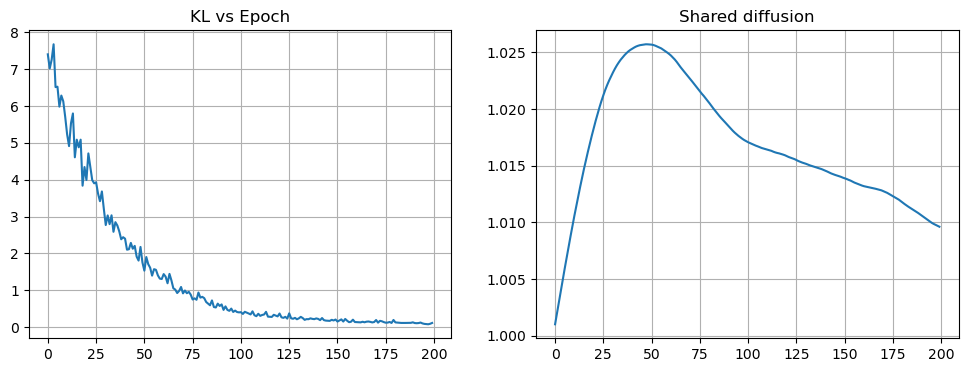

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(kls)
ax[0].grid()
ax[0].set_title(f'KL vs Epoch')
ax[1].plot(sigmas)
ax[1].grid()
ax[1].set_title(f'Shared diffusion')
plt.show()

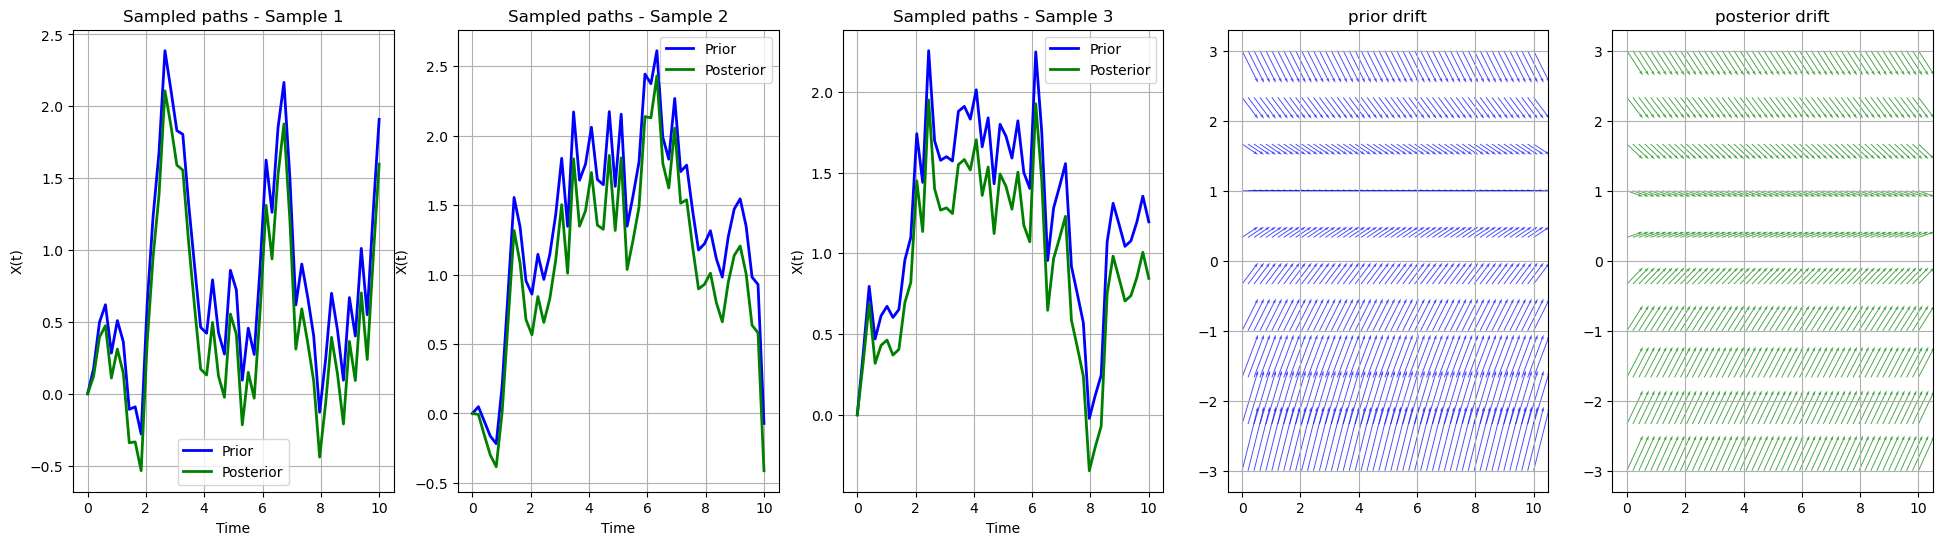

In [65]:
# plot samples of both SDEs
N_SAMPLES = 3
bm = torchsde.BrownianInterval(t_start, t_end, size=(N_SAMPLES,1), device=device)
bm_increments = torch.stack([bm(t0,t1) for t0,t1 in zip(ts[:-1],ts[1:])]) # N_POINTS-1, N_SAMPLES, 1
bm_samples = torch.cat( [torch.zeros(1,N_SAMPLES,1,device=device), torch.cumsum(bm_increments,dim=0)]) # N_POINTS, N_SAMPLES_1

y_start = 0.0
y0s = torch.full((N_SAMPLES,1), y_start).to(device) # N_SAMPLES, 1

# compute paths
with torch.no_grad():
    ys_prior = torchsde.sdeint(prior, y0s, ts, method="euler", dt=1e-3, bm=bm)
    ys_posterior = torchsde.sdeint(posterior, y0s, ts, method="euler", dt=1e-3, bm=bm) # N_POINTS, N_SAMPLES, 1
    
fig, ax = plt.subplots(nrows=1, ncols=N_SAMPLES+2, figsize=(8*N_SAMPLES,6))

for i in range(N_SAMPLES):
    # plot trajectories
    ax[i].plot(ts.detach().cpu().numpy(), ys_prior[:,i,:].detach().cpu().numpy(), lw=2, alpha=1.0, label='Prior', color='blue')
    ax[i].plot(ts.detach().cpu().numpy(), ys_posterior[:,i,:].detach().cpu().numpy(), lw=2, alpha=1.0, label='Posterior', color='green')
    ax[i].set_title(f"Sampled paths - Sample {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("X(t)")
    ax[i].legend()
    ax[i].grid()
    

# compute gradient fields
x_min = torch.tensor(-3.0)
x_max = torch.tensor(+3.0)
N_XS = 10
xs = torch.linspace(x_min, x_max, N_XS).to(device)

T, X = torch.meshgrid(ts, xs, indexing='ij')

ts_flat = T.flatten().unsqueeze(1) # N_POINTS * N_XS, 1
xs_flat = X.flatten().unsqueeze(1) # N_XS * N_POINTS, 1

with torch.no_grad():
    prior_flows = prior.f(ts_flat, xs_flat) # N_XS * N_POINTS, 1
    posterior_flows = posterior.f(ts_flat, xs_flat) # N_XS * N_POINTS, 1
    
# reshape to grid
prior_flows = prior_flows.reshape(T.shape) # N_POINTS, N_XS
posterior_flows = posterior_flows.reshape(T.shape) # N_POINTS, N_XS

# plot
x_points = X.detach().cpu().numpy()
t_points = T.detach().cpu().numpy()
us_prior = prior_flows.detach().cpu().numpy()
us_posterior = posterior_flows.detach().cpu().numpy()

ax[N_SAMPLES].quiver(t_points, x_points, np.ones_like(us_prior), us_prior, scale=20, width=0.003, color='blue', alpha=0.7, label='prior drift')
ax[N_SAMPLES+1].quiver(t_points, x_points, np.ones_like(us_posterior), us_posterior, scale=20, width=0.003, color='green', alpha=0.7, label='posterior drift')
# ax[N_SAMPLES].legend()
ax[N_SAMPLES].grid()
ax[N_SAMPLES+1].grid()
ax[N_SAMPLES].set_title('prior drift')
ax[N_SAMPLES+1].set_title('posterior drift')
    
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Conclusions
</div>
 
- TOY 1 : we can learn the parameters of an O.U. process with a L2 loss and a neural net and torchsde, assuming we build the net as an O.U.

- TOY 2 : we can learn the distribution probability of the parameters of an O.U. process with a L2 loss and a neural net torchsde, assuming we build the net as an O.U.

- TOY 3 : if the SDE to learn is any different from an O.U., if the learning SDE is a drift-MLP and a diffusion-MLP, then training with a L2 loss does not seem successful

- TOY 4 : we set a prior as an O.U., and a posterior as a drift-MLP + shared_diffusion. Learning works by computing a KL between paths.

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Model & Math
</div>

Data : $\mathbf{X} = (x_{t_1}, x_{t_2}, ..., x_{t_N}) \in \mathbb{R}^{D_x}$ - assuming all $t_i \in [0,1]$.

The latent space has dimension $D_z$. The latent continuous dynamic is $\mathbf{Z}$ defined by:
\begin{align*}
z_0^{(\theta)} &\sim p_{\theta_z}(z_0) \\
dz_t^{(\theta)} &= f_{\theta}(z_t, t)dt + \sigma_{\theta}(z_t,t)dB_t 
\end{align*}
with: 
\begin{align}
\textbf{drift} \,& f_{\theta} : \mathbb{R}^{D_z} \times [0,1] \rightarrow \mathbb{R}^{D_z} \\
\textbf{diffusion} \,& \sigma_{\theta} : \mathbb{R}^{D_z} \times [0,1] \rightarrow \mathbb{R}^{D_z \times D_z} \\
\textbf{Brownian motion} \,& dB_t \in \mathbb{R}^{D_z}
\end{align}

The decoder is classically:
\begin{align}
p_{\theta_x}(x_{t_i} \vert z_{t_i})
\end{align}

The approximate posterior (encoder) is also a SDE:
\begin{align}
z_0^{(\phi)} &\sim q_{\phi}(z_0 \vert \textbf{X}) \\
dz_t^{(\phi)} &= f_{\phi}(z_t, t, \textbf{X})dt + \sigma_{\theta}(z_t,t)dB_t 
\end{align}

where:
- the drift $f_{\phi}(z_t, t, \textbf{X})$ is conditionned on observations $\textbf{X}$
- the diffusion of the approximate posterior is shared with the diffusion of the prior : $\sigma_{\theta}(z_t,t)$ - this ensures the application of Girsanov theorem and a finite KL divergence between the two stochastic processes (prior and approximate posterior) (see Generative Modeling of Neural Dynamics via Latent Stochastic Differential Equations (https://arxiv.org/abs/2412.12112) (2024))
- drift and diffusion neural nets do not exhibit the same convergence guarantee (Stable Neural SDEs in analyzing irregular time series data (https://arxiv.org/abs/2402.14989) (2025))
- non-diagonal diffusion seems to be difficult to simulate and costly to approximate (Scalable Gradients for Stochastic Differential Equations (https://arxiv.org/abs/2001.01328) (2020))
- it seems a good practice to encode only part of the $\textbf{X}$ in the approximate posterior : context vector (Scalable Gradients for Stochastic Differential Equations (https://arxiv.org/abs/2001.01328) (2020)), and $t_c << t_n$ in Generative Modeling of Neural Dynamics via Latent Stochastic Differential Equations (https://arxiv.org/abs/2412.12112) (2024).

Variational lower bound on the log marginal likelihood:

We write:
\begin{align}
p(x_{t_1:t_N}) &= \frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{p(z_{t_1:t_N} \vert x_{t_1:t_N})}
\end{align}
And:
\begin{align}
\log{p(x_{t_1:t_N})} &= \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{q_{\phi}(z\vert X)}\frac{q_{\phi}(z\vert X)}{p(z_{t_1:t_N} \vert x_{t_1:t_N})}} dz
\end{align}
where $q_{\phi}(z \vert X)$ is formally is posterior distribution over **functions** $z : \mathbb{R} \rightarrow \mathbb{R}^{D_z}$.
Then:
\begin{align}
\log{p(x_{t_1:t_N})} &= \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{q_{\phi}(z\vert X)}} dz + \mathbb{KL}(q_{\phi}(z\vert X) \vert\vert p(z_{t_1:t_N} \vert x_{t_1:t_N}))
\end{align}
where we -audaciously- consider $p(z_{t_1:t_N} \vert x_{t_1:t_N})$ as a dsitribution over functions $z$ taking values $z_{t_1:t_N}$ at times $t_1:t_N$ so the $\mathbb{KL}$ actually means something.
Still on the same path:
\begin{align}
\log{p(x_{t_1:t_N})} &\geq \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N}, z_{t_1:t_N})}{q_{\phi}(z\vert X)}} dz \\
&= \int q_{\phi}(z \vert X) \log{\frac{p(x_{t_1:t_N} \vert z_{t_1:t_N})}{q_{\phi}(z\vert X)} p(z_{t_1:t_N})} dz \\
&= \mathbb{E}_{q_{\phi}(z \vert X)} \log{p(x_{t_1:t_N} \vert z_{t_1:t_N})} - \mathbb{KL}(q_{\phi}(z\vert X) \vert\vert p(z_{t_1:t_N})) \\
\end{align}
We write -still audaciously-
\begin{align}
\mathbb{KL}(q_{\phi}(z\vert X) \vert\vert p(z_{t_1:t_N})) &= \mathbb{KL}(q_{\phi}(z_0\vert X) \vert\vert p_{\theta_z}(z_0)) + \mathbb{KL}(q_{\phi}(z_{>0}\vert X) \vert\vert p_{\theta_z}(z_{>0}))
\end{align}
where the first $\mathbb{KL}$ on the r.h.s is a classic between two probability distributions over a random variable, and the second is derived from the Girsanov's theorem as:
\begin{align}
\mathbb{KL}(q_{\phi}(z_{>0}\vert X) \vert\vert p_{\theta_z}(z_{>0})) &= \frac{1}{2} \mathbb{E}_{q_{\phi}(z_{>0}\vert X)} \left( \int_{0}^{T} \vert \Delta(t) \vert^2 dt \right) \\
\Delta(t) &= \sigma_{\theta}^{-1}(z_t,t) (f_{\phi}(z_t, t, \textbf{X}) - f_{\theta}(z_t, t))
\end{align}

Finally:
\begin{align}
\mathcal{L}(\theta, \phi, \textbf{X}) &= \mathbb{E}_{q_{\phi}(z \vert X)} \log{p(x_{t_1:t_N} \vert z_{t_1:t_N})} - \mathbb{KL}(q_{\phi}(z_0\vert X) \vert\vert p_{\theta_z}(z_0)) - \frac{1}{2} \mathbb{E}_{q_{\phi}(z_{>0}\vert X)} \left( \int_{0}^{T} \vert \Delta(t) \vert^2 dt \right)
\end{align}

During training:
- the integral is approximated via numerical integration
- expectations are estimated with MC sampling
- NB : sampling is actually : sampling $z_0 \sim q_{\phi}(z_0 \vert \textbf{X})$ and sampling a function $z$ by sampling a Brownian motion path $B_t$ and computing the whole realization path $z_t$.